# Kernel SHAP explanation for SVM models 

## Introduction

In this example, we show how to explain a multi-class classification model based on the SVM algorithm using the `KernelSHAP` method. We show how to perform instance-level (or *local*) explanations on this model as well as how to draw insights about the model behaviour in general by aggregating information from explanations across many instances (that is, perform *global explanations*).

In [1]:
import shap
shap.initjs()

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from alibi.explainers import KernelShap
from sklearn import svm
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Data preparation

In [2]:
wine = load_wine()
wine.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [3]:
data = wine.data
target = wine.target
target_names = wine.target_names
feature_names  = wine.feature_names

Split data into testing and training sets and normalize it.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 142
Testing records: 36


In [5]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

## Fitting a support vector classifier (SVC) to the Wine dataset

### Training 

<a id='intro'></a>

SVM, is a binary classifier, so multiple classifiers are fitted in order to support multiclass classification. The algorithm output is explained [here](#ovr_definition).

In [6]:
np.random.seed(0)
classifier = SVC(
    kernel = 'rbf', 
    C=1, 
    gamma = 0.1, 
    decision_function_shape='ovr',  # n_cls trained with data from one class as postive and remainder of data as neg
    random_state = 0, 
)
classifier.fit(X_train_norm, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

### Model assessment

Look at confusion matrix.

In [7]:
y_pred = classifier.predict(X_test_norm)

In [8]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion matrix for SVC classifier')

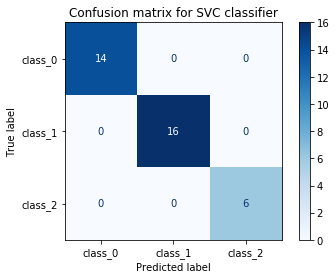

In [9]:
title = 'Confusion matrix for SVC classifier'
disp = plot_confusion_matrix(classifier, 
                             X_test_norm, 
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

The confusion matrix show the classifier is perfect - let's understand what patterns in the data help the SVC perform so well!

## Apply KernelSHAP to explain the model

<a id='ovr_definition'></a>

The model needs access to a function that takes as an input samples and returns predictions to be explained. For an input $z$ the decision function of an _binary_ SVM classifier is given by:

$$
\text{class}(z) = \text{sign}(\beta z + b)
$$

where $\beta$ is the best separating hyperplane (linear combination of support vectors, the training points closest to the separating hyperplane) and $b$ is the bias of the model. 

For the 'one-vs-rest' SVM, `nclass` binary SVM algorithms are fitted using each class as the positive class and the remainder as negative class. The classification decision is taken by assigning the label from the classifier with the maximum absolute decision score. Therefore, to explain our model we could consider explaining the SVM model which outputs the highest decision score. Click here to go back to [source](#intro).

To do so, the KernelSHAP explainer must receive a callable that returns a set of scores when called with an input $X$, in this case the `decision_function` attribute of our classifier. 

In [10]:
pred_fcn = classifier.decision_function

In [11]:
np.random.seed(0)
svm_explainer = KernelShap(pred_fcn)
svm_explainer.fit(X_train_norm)

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KernelShap(meta={
    'name': 'KernelShap',
    'type': ['blackbox'],
    'explanations': ['local', 'global'],
    'params': {
        'groups': None,
        'group_names': None,
        'weights': None,
        'summarise_background': False
    }
})

<a id='source_1'></a>
<a id='f_1'></a>

Note that the explainer is fit to the classifier training set . This training set is used for two purposes:

   - To determine the model output when all inputs are missing ($\phi_0$ in eq. $(5)$ of [[1]](#References). Because the SVM model does not accept arbitrary inputs, this quantity is approximated by averaging the decision score for each class, across the samples in `X_train_norm` as shown below and it is stored as the `expected_value` attribute of the explainer
   - The values of the features in the $N \times D$ `X_train_norm` dataset are used to replace the values missing during the feature attribution ($\phi_i$) estimation process. Specifically, `nsamples` copies of `X_train_norm` are tiled to create a dataset where, for each copy, a subset of features $z'$ of size $s = |z'|$ are replaced by the values in the instance to be explained and the complement of this subset is left to the background dataset value. These background values simulate the effect of *missing values*, since most models cannot cope with arbitrary patterns of missing values at inference time. Therefore, when computing the shap value of a particular feature, $\phi_i$, `nsamples` regression targets ($f(h_x(z'))$ in eq $(5)$ of [[1]](#References)) are computed as the *expected* prediction of the model to be explained when a given subset of features is missing as opposed to replacing the missing feature with a single value. Note that the averaging operation can be replaced by weighted averaging by specifying the `weights` argument to the `fit` method. <sup>[(a)](#Footnotes)</sup>   
   
For the above reason, this is sometimes referred to as the *background dataset*; a larger dataset increases the runtime of the algorithm, so for large datasets, a subset of it should be used. An option to deal with the runtime issue while still providing meaningful values for missing values is to summarise the dataset using the `shap.kmeans` function. This function wraps the `sklearn` k-means clustering implementation, while ensuring that the clusters returned have values that are found in the training data. In addition, the samples are weighted according to the cluster sizes. 

In [12]:
# expected_values attribute stores average scores across training set for every binary SVM 
mean_scores_train = pred_fcn(X_train_norm).mean(axis=0)
# are stored in the expected value attibute of the explainer ...
print(mean_scores_train - svm_explainer.expected_value)  

[-1.11022302e-16  4.44089210e-16 -4.44089210e-16]


In [13]:
svm_explanation = svm_explainer.explain(X_test_norm, l1_reg=False)

<a id='source_2'></a>

In cases where the feature space has higher dimensionality, only a small fraction of the missing subsets can be enumerated for a given number of samples `nsamples`. If the the fraction of the subsets enumerated falls below a fraction (`0.2` for version `0.3.2`) and the regularisation is set to `auto`, a least angle regression with the AIC information criterion for selecting the regularisation coefficient $\alpha$ is performed in order to select features. The regularisation has no effect if the fraction is greater than this threshold and `l1_reg` is not set to `auto`. Other options for regularisations are:
- `l1_reg="num_features(10)"`: in this case, the LARS algorithm [[2](#References)] is used to which 10 features to estimate the shap values for.
- `l1_reg="bic"`: in this case, the least angle regression is run with the Bayes Information Criterion 
- `l1_reg=0.02`: if a float is specified, the $\ell_1$-regularised regression coefficient is set to this value

### Local explanation

Because the SVM algorithm returns a score for each of the $3$ classes, the shap_values are computed for each class in turn. Moreover, the attributions are computed for each data point to be explained and for each feature, resulting in a $N_e \times D$ matrix of shap values for each classs, where $N_e$ is the number of instances to be explained and $D$ is the number of features.

In [14]:
print("Output type:", type(svm_explanation.shap_values))
print("Output size:", len(svm_explanation.shap_values))
print("Class output size:", svm_explanation.shap_values[0].shape)

Output type: <class 'list'>
Output size: 3
Class output size: (36, 13)


For a given instance, we can visualise the attributions using a force plot. Let's choose the first example in the testing set as an example.

In [15]:
idx =  0
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)
scores =  classifier.decision_function(instance)
class_idx = pred.item()
print("The predicted class for the X_test_norm[{}] is {}.".format(idx, *pred))
print("OVR decision function values are {}.".format(*scores))

The predicted class for the X_test_norm[0] is 0.
OVR decision function values are [ 2.24071294  0.85398239 -0.21510456].


We see that class $0$ is predicted because the SVM model trained with class $0$ as a positive class and classes $1$ and $2$ combined as a negative class returned the largest score.

To create this force plot, we have provided the plotting function with four inputs:
- the expected predicted score by the class-0 SVM assuming all inputs are missing. This is marked as the base value on the force plot
- the feature attributions for the instance to be explained 
- the instance to be explained 
- the feature names

In [16]:
shap.force_plot(
    svm_explainer.expected_value[class_idx], 
    svm_explanation.shap_values[class_idx][idx, :] , 
    instance,  
    feature_names,
)

The force plot depicts the contribution of each feature to the process of moving the value of the decision score from the _base value_ (estimation of the decision score if all inputs were missing) to the value predicted by the classifier. We see that all features contribute to increasing the decision score, and that the largest increases are due to the `proline` feature with a value of `1.049` and the `flavanoids` feature with a value of `0.9778`. The lengths of the bars are the corresponding feature attributions.

Similarly, below we see that the `proline` and `alcohol` features contribute the to decreasing the decision score of the   SVM predicting class `1` as positive and that the `malic_acid` feature increases the decision score.

In [17]:
shap.force_plot(
    svm_explainer.expected_value[1], 
    svm_explanation.shap_values[1][idx, :] , 
    instance,  
    feature_names,
)

An alternative way to visualise local explanations for multi-output models is a _multioutput decision plot_. This plot can be especially useful when the number of features is large and the force plot might not be readable.

In [18]:
def class_labels(classifier, instance, class_names=None):
    """
    Creates a set of legend labels based on the decision 
    scores of a classifier and, optionally, the class names.
    """

    decision_scores = classifier.decision_function(instance)
    
    if not class_names:
        class_names = ['Class {}'.format(i) for i in range(decision_scores.shape[1])]
    
    for i, score in enumerate(np.nditer(decision_scores)):
        class_names[i] = class_names[i] + ' ({})'.format(round(score.item(),3))
        
    return class_names
        

In [19]:
legend_labels = class_labels(classifier, instance)

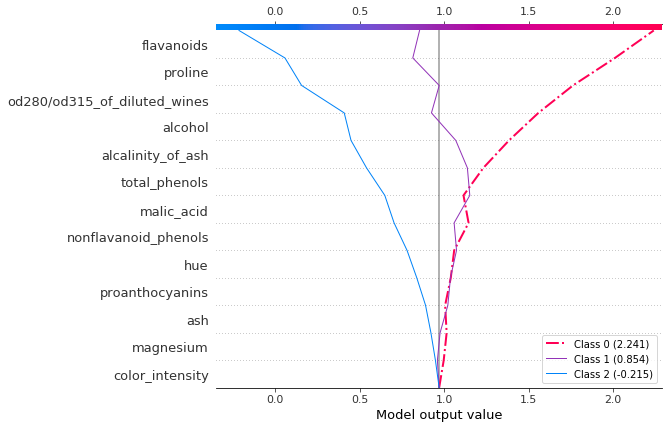

In [20]:
r = shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(), 
                                   svm_explanation.shap_values,
                                   idx, 
                                   feature_names=feature_names, 
                                   feature_order='importance',
                                   highlight=[class_idx],
                                   legend_labels=legend_labels,
                                   return_objects=True,
                                   legend_location='lower right')    

The decision plots shows how the individual features influence contribute to the classification into each of the three classes (a *prediction path*). One sees that, for this example, the model can easily separate the three classes. It also shows, for example, that a wine with the given alcohol content is typical of class `0` (because the `alcohol` feature contributes positively to a classification of class `0` as negatively to classification in classes `1` and `2`)

Note that the feature ordering is determined by summing the shap value magnitudes corresponding to each feature across classes and then ordering the `feature_names` in descending order of cumulative magniture. The plot origin, marked by the gray vertical line, is the average base values across the classes. The dashed line represents the model prediction - in general we can highlight a particular class by passing the class index in the `highlight` list.

Suppose now that we want to analyse instance `5` but realise that the feature importances are different for this instance.

In [21]:
idx =  5
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)

In [22]:
instance_shap = np.array(svm_explanation.shap_values)[:, idx, :]
feature_order = np.argsort(np.sum(np.abs(instance_shap),axis=0))[::-1]
feat_importance = [feature_names[i] for i in feature_order]

In [23]:
print(feat_importance)

['flavanoids', 'alcalinity_of_ash', 'od280/od315_of_diluted_wines', 'alcohol', 'ash', 'total_phenols', 'proline', 'proanthocyanins', 'magnesium', 'hue', 'malic_acid', 'nonflavanoid_phenols', 'color_intensity']


We want to create a multi-output decision plot with the same feature order and scale. This is possible, since by passing the `return_objects=True` to the plotting function in the example above, we retrieved the feature indices and the axis limits and can reuse them to display the decision plot for instance `5` with the same feature order as above.

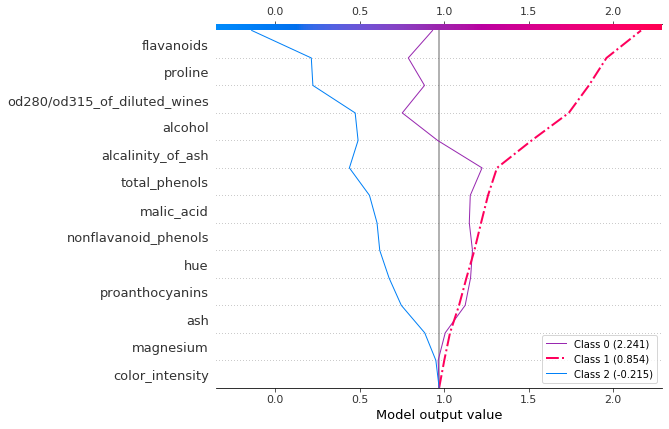

In [24]:
shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(), 
                               svm_explanation.shap_values,
                               idx, 
                               feature_names=feature_names, 
                               feature_order=r.feature_idx,
                               highlight=[pred.item()],
                               legend_labels=legend_labels,
                               legend_location='lower right',
                               xlim=r.xlim,
                               return_objects=False) 

### Global explanation

As shown above, the force plot allows us to understand how the individual features contribute to a classification output *given* an instance. However, the particular explanation does not tell us about the model behaviour in general. Below, we show how such insights can be drawn.

#### Stacked force plots

The simplest way we can do this is to stack the force plot for a number of instances, which can be achieved by calling the `force_plot` function with the same arguments as before but replacing `instance` with the whole testing set, `X_test_norm`.

In [25]:
class_idx = 0 # we explain the predicted label
shap.force_plot(
    svm_explainer.expected_value[class_idx], 
    svm_explanation.shap_values[class_idx], 
    X_test_norm,  
    feature_names,
)

In the default configuration, the `x` axis is represented by the `36` instances in `X_test_norm` whereas the `y` axis represents the decision score. Note that, like before, the decision score is for class `0`. For a given instance, the height in between two horizontal lines is equal to the shap value of the feature, and hovering over a plot shows a list of the features along with their values, sorted by shap values. As before, the blue shading shows a negative contribution to the decision score (moves the score *away* from the baseline value) whereas the pink shading shows a positive contribution to the decision score. Hovering over  the plot, tells us, for example, that to achieve a high decision score (equivalent to memebership `0` membership) the features `proline`  and `flavanoids` are generally the most important and that positive `proline` values lead to higher decision scores for belonging to this class whereas negative proline value provide evidence against this one belonging to `0` class.

To see the relationship between decision scores and the values more clearly, we can permute the `x` axis so that the instances are sorted according to the value of the `proline` feature by selecting `proline` from the horizontal drop down menu.

In [26]:
shap.force_plot(
    svm_explainer.expected_value[class_idx], 
    svm_explanation.shap_values[class_idx], 
    X_test_norm,  
    feature_names,
)

You can also explore the effect of a particular feature across the testing dataset. For example, in the plot below, by selecting `flavanoids` from the top drop-down, the instances are ordered on the  `x` axis in increasing value of the `flavanoids` feature. Similarly, by selecting `flavanoids effects` from the side drop-down will plot the shap value as opposed to the model output. The effect of this feature generally increases as its value increases and the large negative values of this feature reduce the decision score for classification as `0`. Note that the shap values are respresented with resepect to the base value for this class (0.798, as shown below).

In [27]:
shap.force_plot(
    svm_explainer.expected_value[0], 
    svm_explanation.shap_values[0], 
    X_test_norm,  
    feature_names,
)

In [28]:
print(svm_explainer.expected_value)

[0.79821894 1.41710253 0.69461514]


#### Summary plots

To visualise the impact of the features on the decision scores associated with class `0`, we can use a summary plot. In this plot, the features are sorted by the sum of their SHAP values magnitudes across all instances in `X_test_norm`. Therefore, the features with the highest impact on the decision score for class `class_idx` are displayed at the top of the plot.

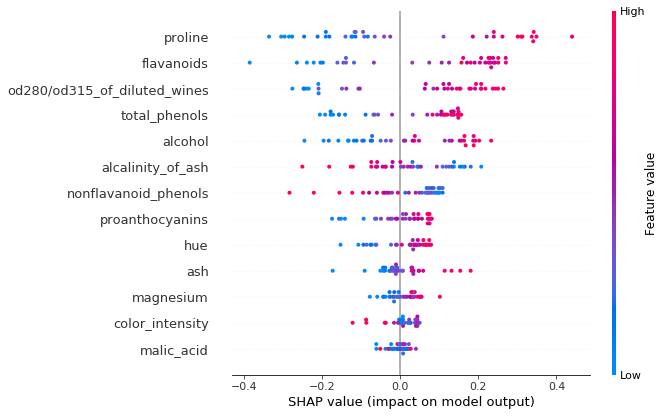

In [29]:
shap.summary_plot(svm_explanation.shap_values[0], X_test_norm, feature_names)

In this case, the `proline` and `flavanoids` have the most impact on the model output; as the values of the features increase, their impact also increases and the model is more likely to predict class `0`. On the other hand, high values of the `nonflavonoid_phenols` have a negative impact on the model output, potentially contributing to the classification of the particular wine in a different class. To see this, we do a summary plot with respect to `class_2`.

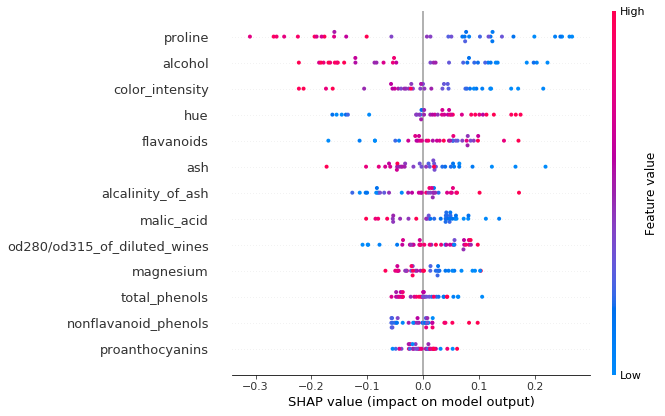

In [30]:
shap.summary_plot(svm_explanation.shap_values[1], X_test_norm, feature_names)

We see that, indeed, a higher value of the `nonflavonoid_phenols` feature contributes to a sample being classified as class `1`, but that this effect is rather limited compared to features such as `proline` or `alcohol`.

To visualise the impact of the feature across all classes, that is, the importance of a particular feature for the model, we simply pass all the shap values to the `summary_plot` functions. We see, that, for example, the `color_intensity` feature is much more important for deciding whether an instance should be classified as `class_2` then in `class_0`.

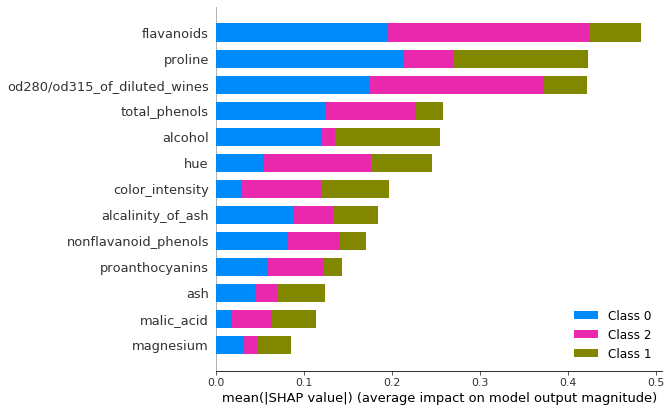

In [31]:
shap.summary_plot(svm_explanation.shap_values, X_test_norm, feature_names)

#### Dependence plots

Another way to visualise the model dependence on a particular feature is through a dependence plot. This plot shows the impact of the feature value on its importance for classification with respect to class `0`.

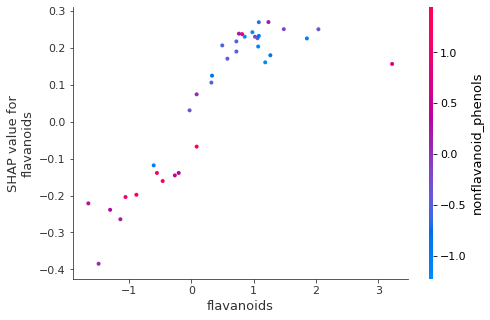

In [32]:
feature = 'flavanoids'
shap.dependence_plot(
    feature, 
    svm_explanation.shap_values[0], 
    X_test_norm, 
    feature_names=feature_names,
    interaction_index='auto',
)

The colour of the individual instances is represented by the value of the feature `nonflavanoid_phenols`. By specifying `interaction_index=auto`, the `nonflavanoid_phenols` was estimated as a the feature with the strongest interaction with the `flavanoids_feature`; this interaction is approximate, and is estimate by computing the Pearson Correlation Coefficient between the shap values of the reference feature (`flavanoids` in this case) and the value of each feature in turn on bins along the feature value. 

We see that, for class `0` wines, a higher value for `nonfavanoid_phenols` is generally associated with a low value in `flavanoids` and that they have a negative impact on the score for class `0` classification.

### Footnotes

<a id='Footnotes'></a>

[(a)](#f_1) The weights are applied to each point in a copy, so the number of weights should be the same as the number of samples in the data.

### References

<a id='References'></a>

[[1]](#source_1) Lundberg, S.M. and Lee, S.I., 2017. A unified approach to interpreting model predictions. In Advances in neural information processing systems (pp. 4765-4774).

[[2]](#source_2) Wikipedia entry on the Least-angle regression: <https://en.wikipedia.org/wiki/Least-angle_regression>.